# Experiments Adversarial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import wandb

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily


from adversarial_sb.adversarial_ipfp import AdversarialIPFPTrainer
from adversarial_sb.models import SimpleConditional, SimpleCritic, Conditional, Critic
from adversarial_sb.data import OneVariateDataset, MoonsDataset, CirclesDataset, LettersDataset, DigitsDataset, GaussianDataset, SwissRollDataset
from adversarial_sb.utils import visualize_losses, visualize_sb, visualize_sb_images, visualize_gamma

from cycle_gan.cycle_gan import CycleGANTrainer
from cycle_gan.gan import GAN
from cycle_gan.utils import visualize_cycle_gan


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# One variate

## One mode

In [51]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = Normal(5, 1)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 120,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/120 [00:00<?, ?it/s]

gen Loss: 0.9602499842643738, disc Real Loss: 0.7983833596110343, disc Fake Loss: 0.4910175256431103


KeyboardInterrupt: 

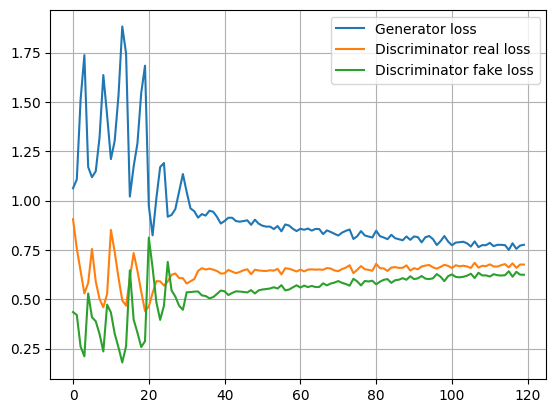

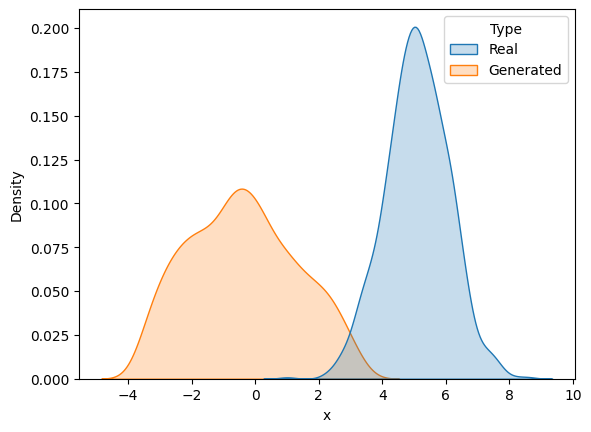

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 80
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.28373, disc_b_fixed: -0.23165, disc_b_training: -0.28385
Backward cond_p: 0.99555, disc_b_fixed: -0.31146, disc_b_training: 0.99489
Backward cond_p: 1.66834, disc_b_fixed: -0.26791, disc_b_training: 1.66830
Backward cond_p: 1.99952, disc_b_fixed: -0.17066, disc_b_training: 1.99945
Backward cond_p: 2.08107, disc_b_fixed: -0.11206, disc_b_training: 2.08110
Forward cond_q: 0.11598, disc_f_fixed: -0.56669, disc_f_training: 0.11587
Forward cond_q: 0.84751, disc_f_fixed: -0.33146, disc_f_training: 0.84384
Forward cond_q: 1.55291, disc_f_fixed: -0.27755, disc_f_training: 1.56263
Forward cond_q: 2.16279, disc_f_fixed: -0.20048, disc_f_training: 2.16318
Forward cond_q: 2.35231, disc_f_fixed: -0.21499, disc_f_training: 2.35589
======= Epoch 1 =======
Backward cond_p: 2.02779, disc_b_fixed: -0.31762, disc_b_training: 2.02537
Backward cond_p: 2.03402, disc_b_fixed: -0.17846, disc_b_training: 2.03334
Backward cond_p: 2.05206, disc_b_fixed: -0.16846, disc_

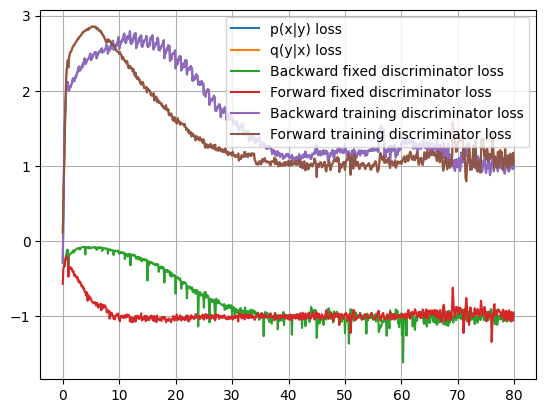

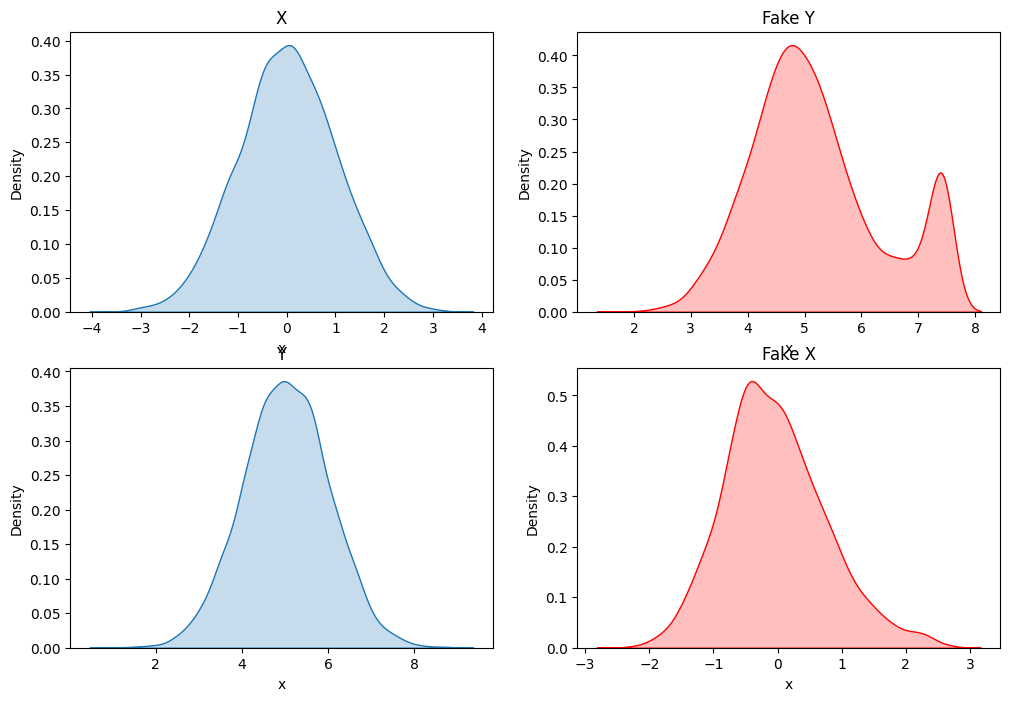

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

## Two modes

In [ ]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 500,
    'loader': dataloader,
    'gamma': 10.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/500 [00:00<?, ?it/s]

AttributeError: 'list' object has no attribute 'to'

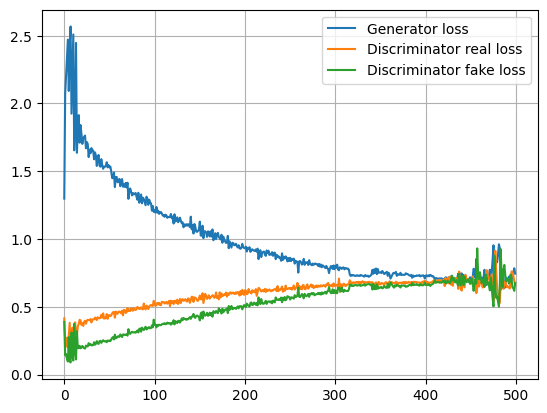

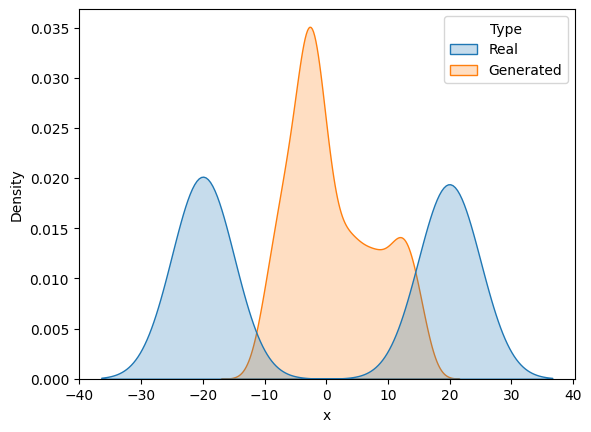

In [ ]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 100
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.06882, disc_b_fixed: -0.38241, disc_b_training: 0.06879
Backward cond_p: 0.98676, disc_b_fixed: -0.71167, disc_b_training: 0.98666
Backward cond_p: 1.46368, disc_b_fixed: -0.64175, disc_b_training: 1.46345
Backward cond_p: 1.90606, disc_b_fixed: -0.48748, disc_b_training: 1.90594
Backward cond_p: 2.20280, disc_b_fixed: -0.28178, disc_b_training: 2.20246
Forward cond_q: 0.23523, disc_f_fixed: -0.52472, disc_f_training: 0.23874
Forward cond_q: 0.98505, disc_f_fixed: -0.78373, disc_f_training: 0.98823
Forward cond_q: 1.17830, disc_f_fixed: -0.69772, disc_f_training: 1.18277
Forward cond_q: 1.40036, disc_f_fixed: -0.55383, disc_f_training: 1.38292
Forward cond_q: 1.66683, disc_f_fixed: -0.34991, disc_f_training: 1.66477
======= Epoch 1 =======
Backward cond_p: 2.44365, disc_b_fixed: -0.23275, disc_b_training: 2.44257
Backward cond_p: 2.45283, disc_b_fixed: -0.23858, disc_b_training: 2.44970
Backward cond_p: 2.42948, disc_b_fixed: -0.23914, disc_b_

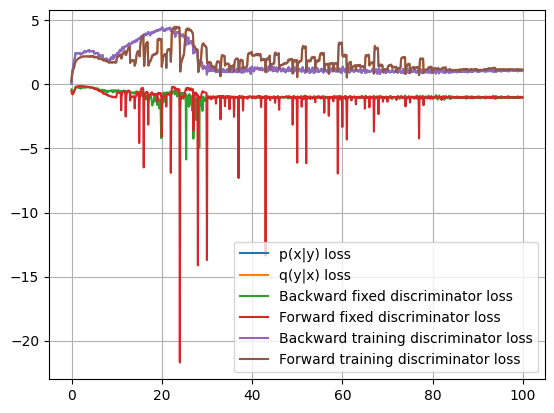

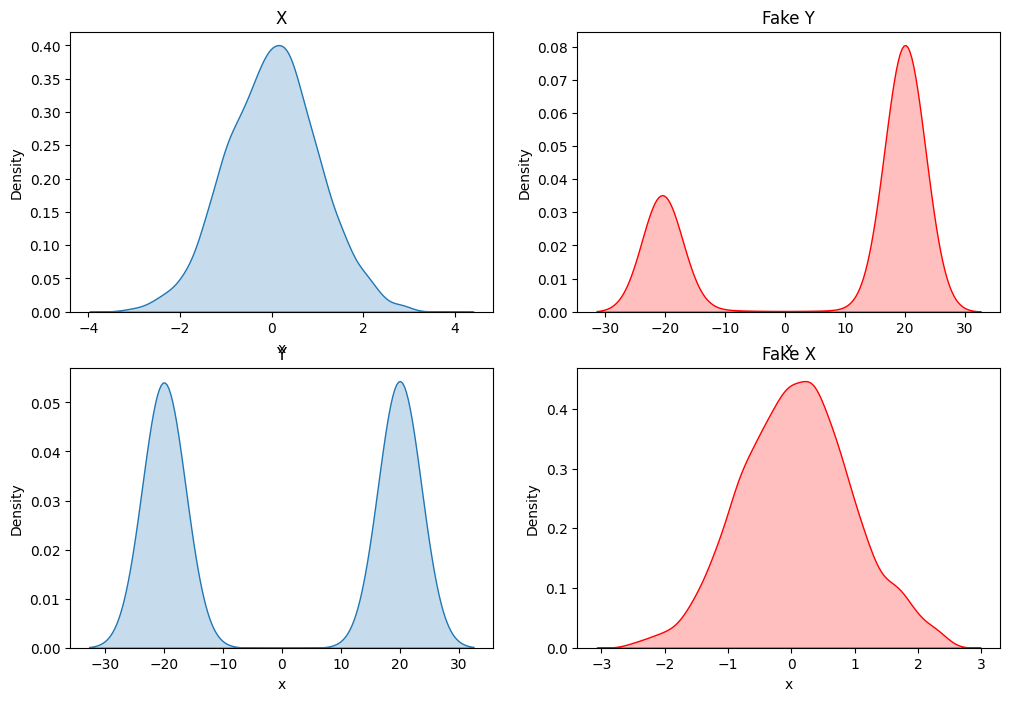

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 200
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.49170, disc_b_fixed: -0.56104, disc_b_training: 0.49169
Backward cond_p: 1.22511, disc_b_fixed: -0.81365, disc_b_training: 1.22504
Backward cond_p: 1.77094, disc_b_fixed: -0.65629, disc_b_training: 1.77089
Backward cond_p: 2.13138, disc_b_fixed: -0.46380, disc_b_training: 2.13141
Backward cond_p: 2.38483, disc_b_fixed: -0.29647, disc_b_training: 2.38470
Forward cond_q: 0.47034, disc_f_fixed: -0.59313, disc_f_training: 0.46639
Forward cond_q: 1.04808, disc_f_fixed: -0.73477, disc_f_training: 1.04901
Forward cond_q: 1.33726, disc_f_fixed: -0.63250, disc_f_training: 1.32820
Forward cond_q: 1.61513, disc_f_fixed: -0.35247, disc_f_training: 1.61887
Forward cond_q: 1.85230, disc_f_fixed: -0.12371, disc_f_training: 1.85272
======= Epoch 1 =======
Backward cond_p: 2.58021, disc_b_fixed: -0.17707, disc_b_training: 2.57999
Backward cond_p: 2.59820, disc_b_fixed: -0.16780, disc_b_training: 2.59848
Backward cond_p: 2.61076, disc_b_fixed: -0.17046, disc_b_

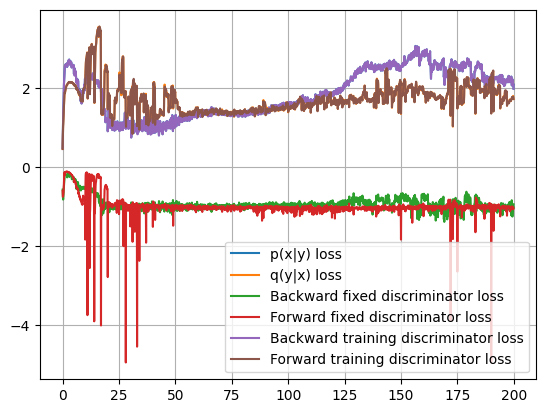

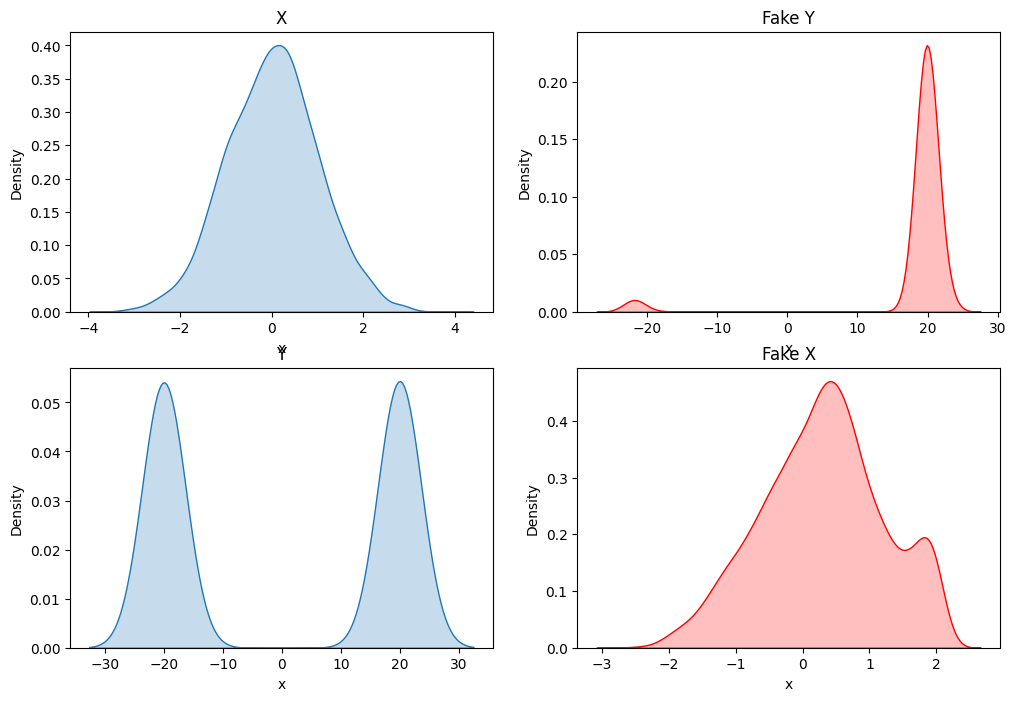

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [ ]:
from copy import deepcopy

discriminator_backward = SimpleCritic(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleCritic(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 5e-5, 'backward': 5e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.001,
    device=device
)

epochs = 150
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.45783, disc_b_fixed: -0.64404, disc_b_training: 0.45779
Backward cond_p: 1.14569, disc_b_fixed: -0.77818, disc_b_training: 1.14552
Backward cond_p: 1.61054, disc_b_fixed: -0.51371, disc_b_training: 1.61032
Backward cond_p: 1.69893, disc_b_fixed: -0.46949, disc_b_training: 1.69885
Backward cond_p: 1.78507, disc_b_fixed: -0.41947, disc_b_training: 1.78381
Forward cond_q: 0.20120, disc_f_fixed: -0.50091, disc_f_training: 0.20646
Forward cond_q: 1.16796, disc_f_fixed: -0.72731, disc_f_training: 1.17349
Forward cond_q: 1.56670, disc_f_fixed: -0.55274, disc_f_training: 1.55276
Forward cond_q: 1.82607, disc_f_fixed: -0.23926, disc_f_training: 1.84101
Forward cond_q: 1.97565, disc_f_fixed: -0.15433, disc_f_training: 1.97312
======= Epoch 1 =======
Backward cond_p: 1.94056, disc_b_fixed: -0.66301, disc_b_training: 1.92121
Backward cond_p: 2.12373, disc_b_fixed: -0.46204, disc_b_training: 2.11118
Backward cond_p: 2.12963, disc_b_fixed: -0.48058, disc_b_

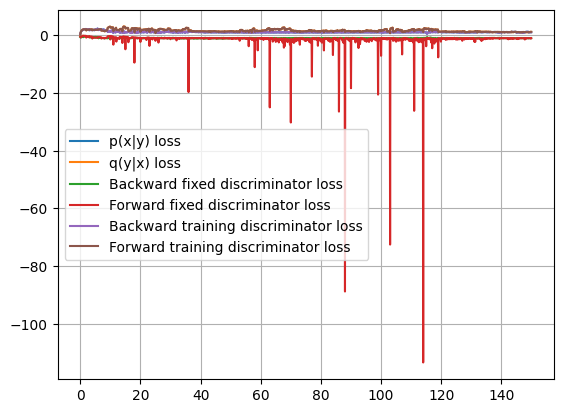

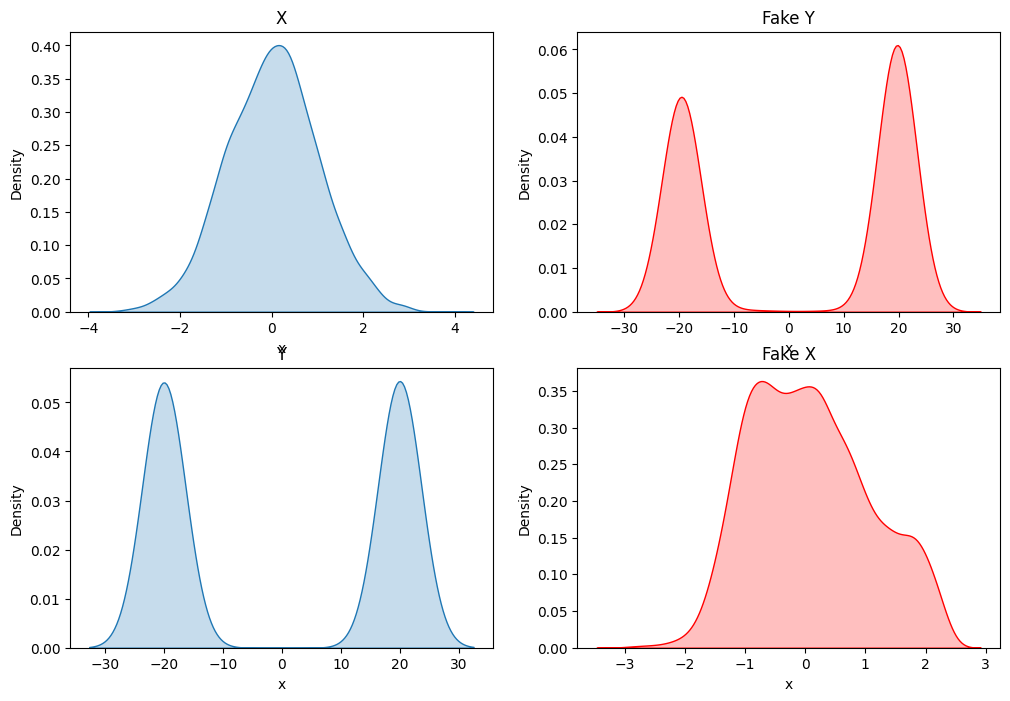

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

# Two variate

In [2]:
batch_size = 1024

moons_set = MoonsDataset(4096)
circles_set = CirclesDataset(4096)

moons = DataLoader(moons_set, batch_size=batch_size, shuffle=True)
circles = DataLoader(circles_set, batch_size=batch_size, shuffle=True)

In [3]:
# Models parameters
data_dim = 2
hidden_dims = [256, 256, 256]

In [4]:
discriminator_backward0 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward0 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)


conditional_p0 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q0 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p0,
    conditional_q0,
    discriminator_backward0,
    discriminator_forward0,
    gamma=0.1,
    lr_disc={'forward': 1e-6, 'backward': 1e-6},
    lr_gen={'forward': 1e-6, 'backward': 1e-6}, 
    device=device
)

losses0 = trainer.train(400, circles, moons, inner_steps=60)

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.33731, disc_b_fixed: 0.24689, disc_b_training: 0.33818
Backward cond_p: -0.32146, disc_b_fixed: 0.24975, disc_b_training: 0.32257
Backward cond_p: -0.30420, disc_b_fixed: 0.25289, disc_b_training: 0.30694
Backward cond_p: -0.28627, disc_b_fixed: 0.25596, disc_b_training: 0.29060
Backward cond_p: -0.27184, disc_b_fixed: 0.25862, disc_b_training: 0.27265
Backward cond_p: -0.25383, disc_b_fixed: 0.26226, disc_b_training: 0.25599
Backward cond_p: -0.23617, disc_b_fixed: 0.26482, disc_b_training: 0.24001
Backward cond_p: -0.21814, disc_b_fixed: 0.26767, disc_b_training: 0.22136
Backward cond_p: -0.20218, disc_b_fixed: 0.27050, disc_b_training: 0.20515
Backward cond_p: -0.18395, disc_b_fixed: 0.27223, disc_b_training: 0.18675
Backward cond_p: -0.16663, disc_b_fixed: 0.27480, disc_b_training: 0.16884
Backward cond_p: -0.14742, disc_b_fixed: 0.27748, disc_b_training: 0.15213
Backward cond_p: -0.12973, disc_b_fixed: 0.27948, disc_b_training: 0.13379
B

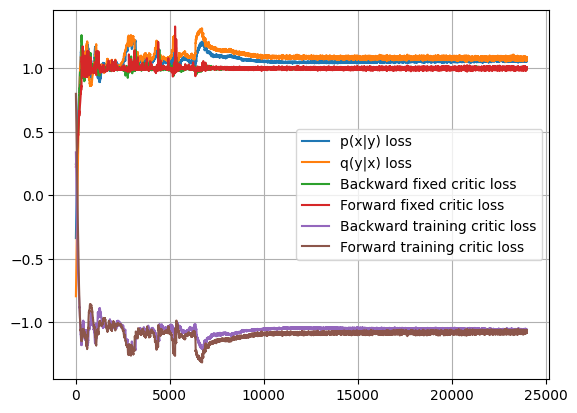

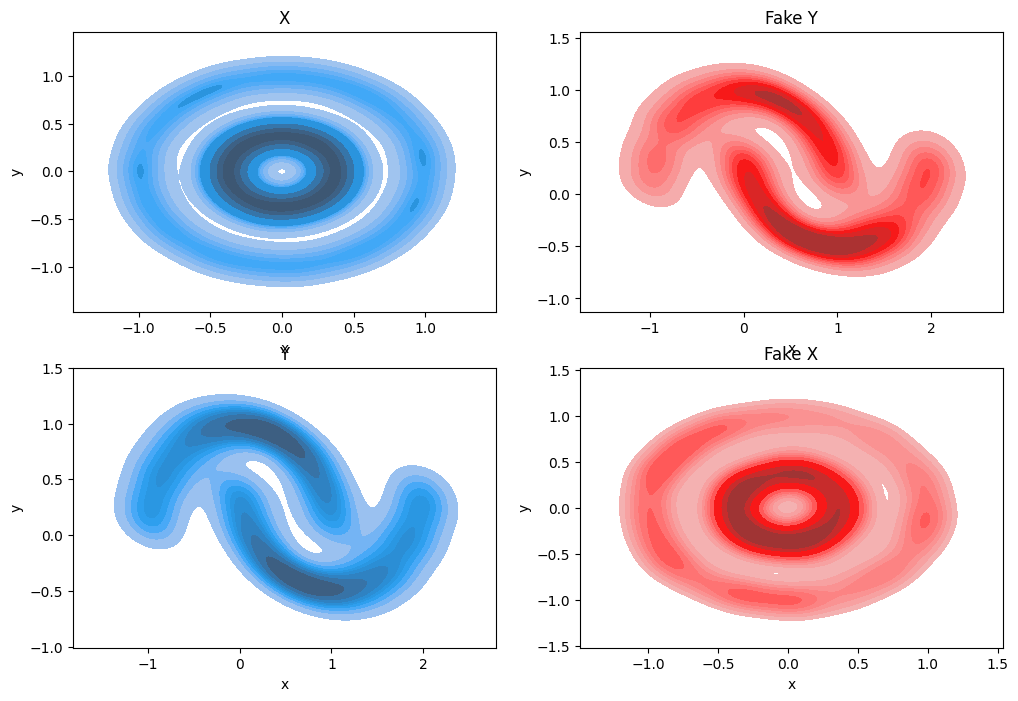

In [5]:
conditional_q0.cpu()
conditional_p0.cpu()

visualize_losses(losses0, trainer.loss_titles)
visualize_sb(conditional_p0, conditional_q0, circles_set, moons_set, num_samples=len(circles_set))

In [6]:
batch_size = 1024

swiss_roll_set = SwissRollDataset(4096)
gaussian_set = GaussianDataset(4096)

swiss_roll = DataLoader(swiss_roll_set, batch_size=batch_size, shuffle=True)
gaussian = DataLoader(gaussian_set, batch_size=batch_size, shuffle=True)

In [17]:
discriminator_backward1 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward1 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)


conditional_p1 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q1 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p1,
    conditional_q1,
    discriminator_backward1,
    discriminator_forward1,
    gamma=0.1,
    lr_disc={'forward': 5e-7, 'backward': 5e-7},
    lr_gen={'forward': 5e-7, 'backward': 5e-7}, 
    device=device
)

losses1 = trainer.train(500, swiss_roll, gaussian, inner_steps=60)

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.73544, disc_b_fixed: 0.67748, disc_b_training: -0.73390
Backward cond_p: 0.74045, disc_b_fixed: 0.68011, disc_b_training: -0.73727
Backward cond_p: 0.74564, disc_b_fixed: 0.68102, disc_b_training: -0.74462
Backward cond_p: 0.74768, disc_b_fixed: 0.68312, disc_b_training: -0.74753
Backward cond_p: 0.75418, disc_b_fixed: 0.68555, disc_b_training: -0.75385
Backward cond_p: 0.75851, disc_b_fixed: 0.68727, disc_b_training: -0.75886
Backward cond_p: 0.76122, disc_b_fixed: 0.68938, disc_b_training: -0.76438
Backward cond_p: 0.76694, disc_b_fixed: 0.69158, disc_b_training: -0.76689
Backward cond_p: 0.77393, disc_b_fixed: 0.69312, disc_b_training: -0.77191
Backward cond_p: 0.77853, disc_b_fixed: 0.69460, disc_b_training: -0.77720
Backward cond_p: 0.78240, disc_b_fixed: 0.69665, disc_b_training: -0.78090
Backward cond_p: 0.78463, disc_b_fixed: 0.69922, disc_b_training: -0.78519
Backward cond_p: 0.79376, disc_b_fixed: 0.70170, disc_b_training: -0.78878
B

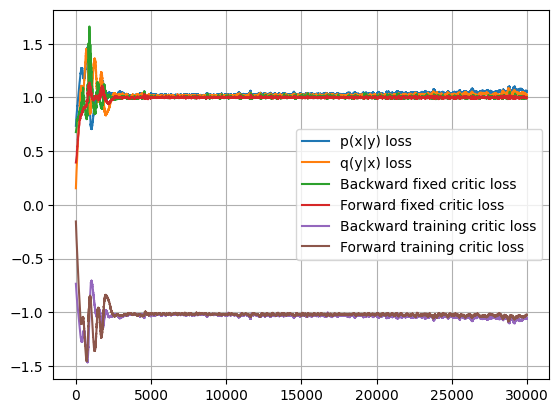

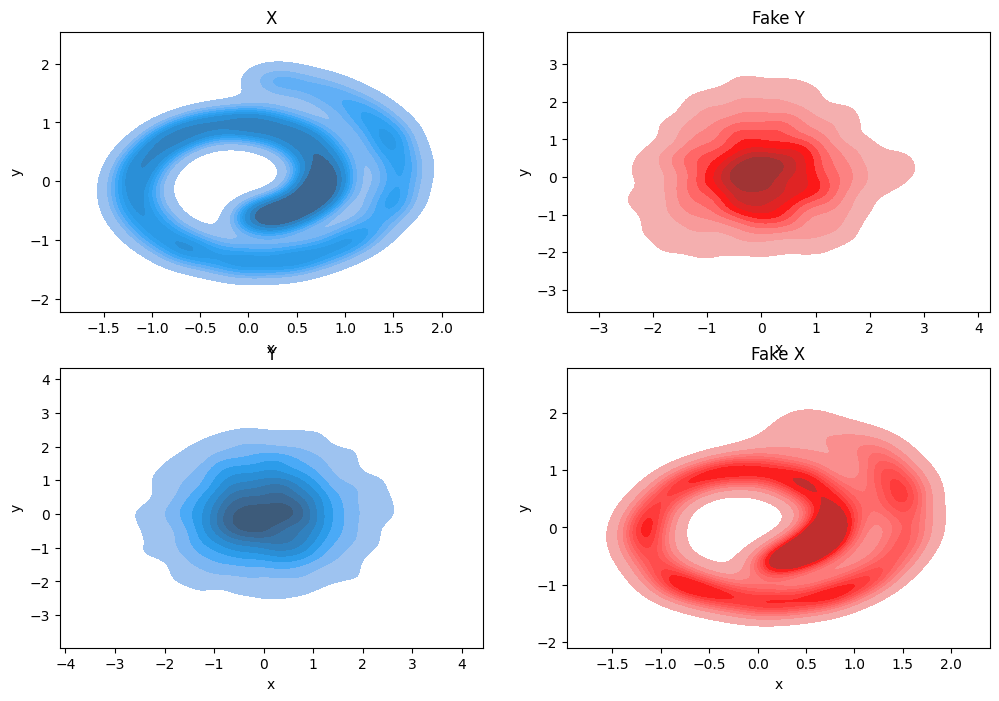

In [18]:
conditional_q1.cpu()
conditional_p1.cpu()

visualize_losses(losses1, trainer.loss_titles)
visualize_sb(conditional_p1, conditional_q1, swiss_roll_set, gaussian_set, num_samples=len(gaussian_set))

In [19]:
discriminator_backward2 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward2 = SimpleCritic(data_dim, hidden_dims=hidden_dims).to(device)

conditional_p2 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q2 = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p2,
    conditional_q2,
    discriminator_backward2,
    discriminator_forward2,
    gamma=0.001,
    lr_disc={'forward': 5e-7, 'backward': 5e-7},
    lr_gen={'forward': 5e-7, 'backward': 5e-7}, 
    device=device
)

losses2 = trainer.train(500, swiss_roll, gaussian, inner_steps=60)

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.60582, disc_b_fixed: 0.57237, disc_b_training: -0.60466
Backward cond_p: 0.61212, disc_b_fixed: 0.57488, disc_b_training: -0.61046
Backward cond_p: 0.62006, disc_b_fixed: 0.57739, disc_b_training: -0.61688
Backward cond_p: 0.62483, disc_b_fixed: 0.57990, disc_b_training: -0.62393
Backward cond_p: 0.63007, disc_b_fixed: 0.58239, disc_b_training: -0.62964
Backward cond_p: 0.63665, disc_b_fixed: 0.58487, disc_b_training: -0.63397
Backward cond_p: 0.64186, disc_b_fixed: 0.58735, disc_b_training: -0.64155
Backward cond_p: 0.64987, disc_b_fixed: 0.58981, disc_b_training: -0.64751
Backward cond_p: 0.65548, disc_b_fixed: 0.59224, disc_b_training: -0.65255
Backward cond_p: 0.65962, disc_b_fixed: 0.59466, disc_b_training: -0.66045
Backward cond_p: 0.66510, disc_b_fixed: 0.59707, disc_b_training: -0.66519
Backward cond_p: 0.67318, disc_b_fixed: 0.59947, disc_b_training: -0.67204
Backward cond_p: 0.67890, disc_b_fixed: 0.60185, disc_b_training: -0.67635
B

Backward cond_p: 0.69487, disc_b_fixed: 0.60892, disc_b_training: -0.69289
Backward cond_p: 0.69971, disc_b_fixed: 0.61126, disc_b_training: -0.69984
Backward cond_p: 0.70443, disc_b_fixed: 0.61357, disc_b_training: -0.70593
Backward cond_p: 0.71142, disc_b_fixed: 0.61588, disc_b_training: -0.71135
Backward cond_p: 0.71717, disc_b_fixed: 0.61817, disc_b_training: -0.71542
Backward cond_p: 0.72209, disc_b_fixed: 0.62046, disc_b_training: -0.72076
Backward cond_p: 0.72578, disc_b_fixed: 0.62273, disc_b_training: -0.72755
Backward cond_p: 0.73053, disc_b_fixed: 0.62499, disc_b_training: -0.73107
Backward cond_p: 0.73865, disc_b_fixed: 0.62721, disc_b_training: -0.73824
Backward cond_p: 0.74222, disc_b_fixed: 0.62944, disc_b_training: -0.74293
Backward cond_p: 0.74895, disc_b_fixed: 0.63165, disc_b_training: -0.74947
Backward cond_p: 0.75375, disc_b_fixed: 0.63384, disc_b_training: -0.75310
Backward cond_p: 0.76034, disc_b_fixed: 0.63603, disc_b_training: -0.76101
Backward cond_p: 0.76615,

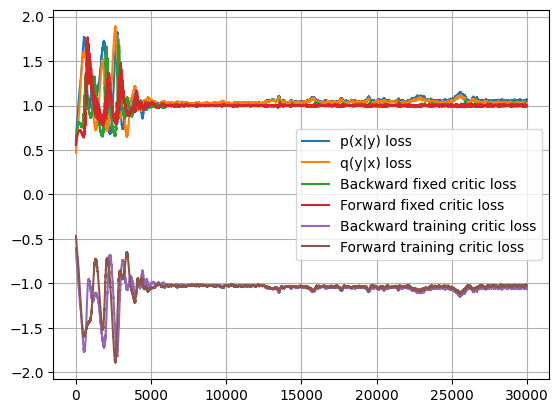

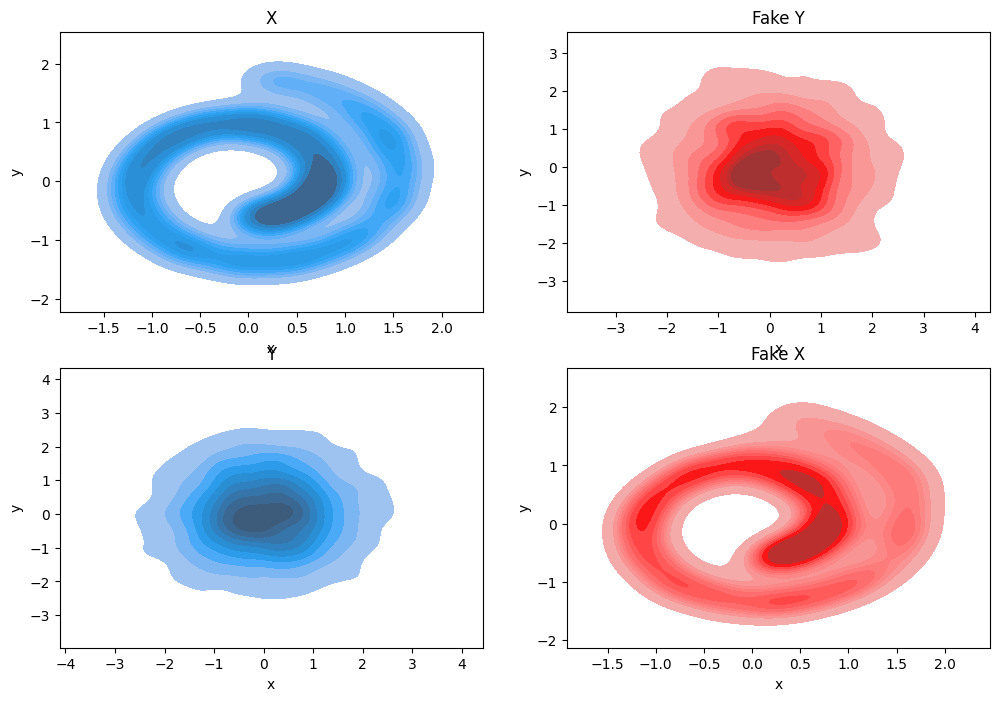

In [20]:
conditional_q2.cpu()
conditional_p2.cpu()

visualize_losses(losses2, trainer.loss_titles)
visualize_sb(conditional_p2, conditional_q2, swiss_roll_set, gaussian_set, num_samples=len(gaussian_set))

In [28]:
torch.save(conditional_p0.state_dict(), '../models/simple_conditional_p0.pt')
torch.save(conditional_q0.state_dict(), '../models/simple_conditional_q0.pt')

torch.save(conditional_p1.state_dict(), '../models/simple_conditional_p1.pt')
torch.save(conditional_q1.state_dict(), '../models/simple_conditional_q1.pt')

torch.save(conditional_p2.state_dict(), '../models/simple_conditional_p2.pt')
torch.save(conditional_q2.state_dict(), '../models/simple_conditional_q2.pt')

In [5]:
conditional_p1 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_q1 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_p1.load_state_dict(torch.load('../models/simple_conditional_p1.pt'))
conditional_q1.load_state_dict(torch.load('../models/simple_conditional_q1.pt'))
conditional_p1 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_q1 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_p1.load_state_dict(torch.load('../models/simple_conditional_p1.pt'))
conditional_q1.load_state_dict(torch.load('../models/simple_conditional_q1.pt'))

conditional_p2 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_q2 = SimpleConditional(data_dim, hidden_dims=hidden_dims)
conditional_p2.load_state_dict(torch.load('../models/simple_conditional_p2.pt'))
conditional_q2.load_state_dict(torch.load('../models/simple_conditional_q2.pt'))

<All keys matched successfully>

In [21]:
gan_x = GAN().to(device)
gan_y = GAN().to(device)

cycle_gan_trainer = CycleGANTrainer(gan_x, gan_y, lr_disc=1e-3, lr_gen=1e-3, device=device)
losses_cycle_gan = cycle_gan_trainer.train(700, swiss_roll, gaussian)

  0%|          | 0/700 [00:00<?, ?it/s]

gen Loss: 13.975910902023315, disc Real Loss: 0.6827997714281082, disc Fake Loss: 0.7024300247430801
gen Loss: 13.716057062149048, disc Real Loss: 0.671286940574646, disc Fake Loss: 0.7011173516511917
gen Loss: 13.464209794998169, disc Real Loss: 0.6596788316965103, disc Fake Loss: 0.70126973092556
gen Loss: 13.196887969970703, disc Real Loss: 0.6472829282283783, disc Fake Loss: 0.7020381540060043
gen Loss: 12.891685962677002, disc Real Loss: 0.6331042647361755, disc Fake Loss: 0.7039001435041428
gen Loss: 12.516236066818237, disc Real Loss: 0.6177913099527359, disc Fake Loss: 0.7066598534584045
gen Loss: 12.051278352737427, disc Real Loss: 0.6022535562515259, disc Fake Loss: 0.710938349366188
gen Loss: 11.483668327331543, disc Real Loss: 0.5871871262788773, disc Fake Loss: 0.7169564515352249
gen Loss: 10.777639389038086, disc Real Loss: 0.5734922587871552, disc Fake Loss: 0.7235558480024338
gen Loss: 9.892120122909546, disc Real Loss: 0.5616727322340012, disc Fake Loss: 0.730206519365

gen Loss: 0.8072058856487274, disc Real Loss: 0.6859285533428192, disc Fake Loss: 0.6643433123826981
gen Loss: 0.80098457634449, disc Real Loss: 0.6883000731468201, disc Fake Loss: 0.6596133559942245
gen Loss: 0.7944826036691666, disc Real Loss: 0.687760666012764, disc Fake Loss: 0.6579708755016327
gen Loss: 0.7883598804473877, disc Real Loss: 0.685278907418251, disc Fake Loss: 0.658811166882515
gen Loss: 0.7838072329759598, disc Real Loss: 0.6827478557825089, disc Fake Loss: 0.6596106290817261
gen Loss: 0.7821546792984009, disc Real Loss: 0.6819470524787903, disc Fake Loss: 0.6584999859333038
gen Loss: 0.7813230007886887, disc Real Loss: 0.6813299804925919, disc Fake Loss: 0.6569454669952393
gen Loss: 0.7807585746049881, disc Real Loss: 0.6797744482755661, disc Fake Loss: 0.6561331003904343
gen Loss: 0.7823653072118759, disc Real Loss: 0.6799870133399963, disc Fake Loss: 0.6528619527816772
gen Loss: 0.7836290150880814, disc Real Loss: 0.6793794333934784, disc Fake Loss: 0.650108888745

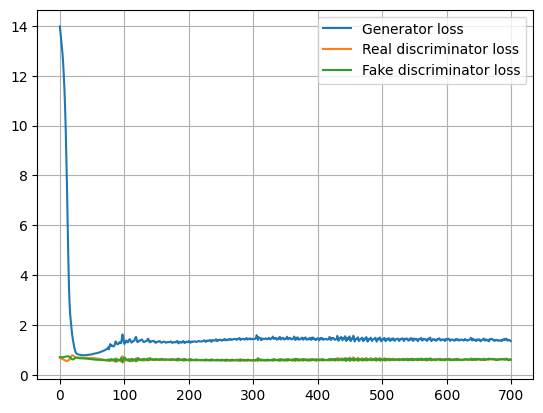

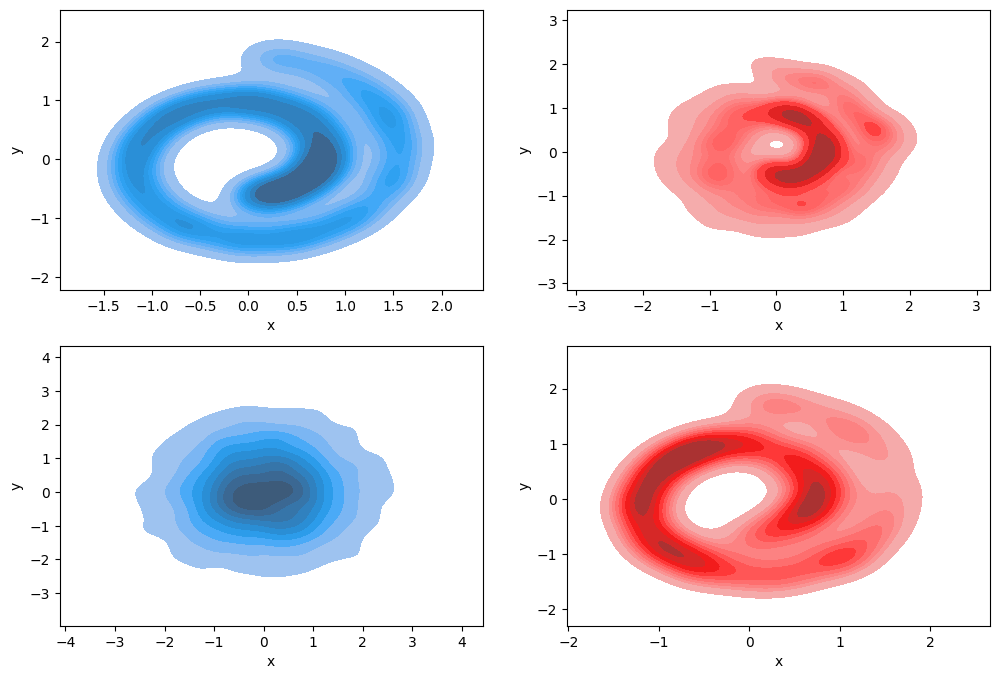

In [22]:
gan_x.cpu()
gan_y.cpu()

visualize_losses(losses_cycle_gan, cycle_gan_trainer.loss_titles)
visualize_cycle_gan(gan_x, gan_y, swiss_roll_set, gaussian_set)

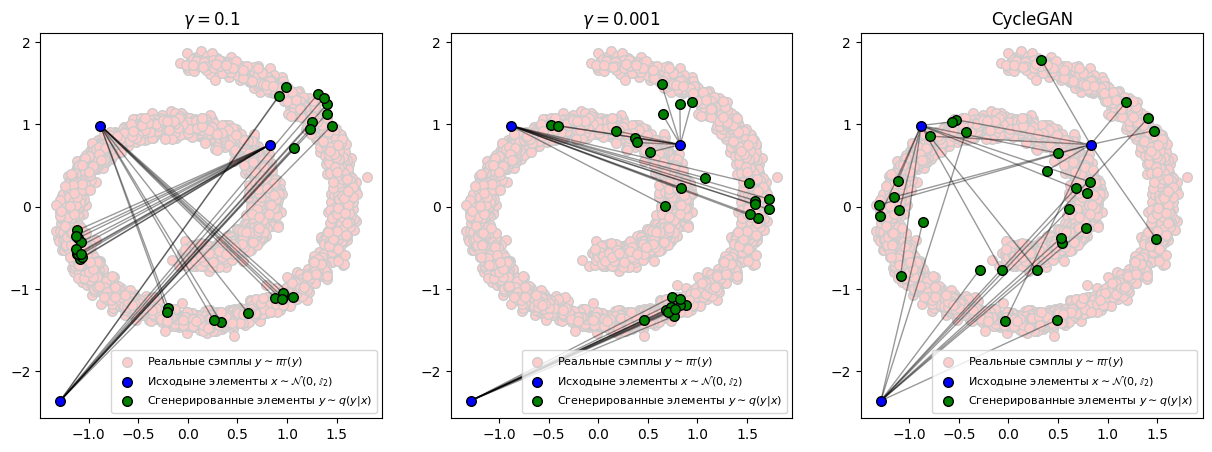

In [27]:
visualize_gamma([conditional_p1, conditional_p2, gan_x], gaussian_set, swiss_roll_set, titles=[r'$\gamma=0.1$', r'$\gamma=0.001$', 'CycleGAN'])

# Images: Letters $\rightarrow$ Digits

In [107]:
hyper_params = {
    'data': {
        'batch_size': 4096,
        'dataset': 'Letters <-> Digits'
    },
    'train': {
        'gamma': 1,
        'lr_disc': {'forward': 1e-6, 'backward': 1e-6},
        'lr_gen': {'forward': 1e-6, 'backward': 1e-6},
        'epochs': 400,
        'inner_steps': 60,
    }
}
batch_size = hyper_params['data']['batch_size']

letters_set = LettersDataset('../data/emnist/emnist-letters-train.csv')
digits_set = DigitsDataset('../data/emnist/emnist-mnist-train.csv')

letters = DataLoader(letters_set, batch_size=batch_size, shuffle=True)
digits = DataLoader(digits_set, batch_size=batch_size, shuffle=True)

In [20]:
wandb.login()
wandb.init(
    project="adversarial-sb",
    notes="EMNIST",
    config=hyper_params
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [109]:
for batch in letters:
    yhat = conditional_p(batch) # Give dummy batch to forward().
    break

from torchviz import make_dot

make_dot(yhat, params=dict(list(conditional_p.named_parameters()))).render("rnn_torchviz", format="png")


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [110]:
discriminator_backward = Critic(hidden_dims=[256, 128, 64]).to(device)
discriminator_forward = Critic(hidden_dims=[256, 128, 64]).to(device)

conditional_p = Conditional(hidden_dims=[256, 128, 256]).to(device)
conditional_q = Conditional(hidden_dims=[256, 128, 256]).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    gamma=hyper_params['train']['gamma'],
    lr_disc=hyper_params['train']['lr_disc'],
    lr_gen=hyper_params['train']['lr_gen'],
    device=device
)

losses = trainer.train(hyper_params['train']['epochs'], letters, digits, inner_steps=hyper_params['train']['inner_steps'])

Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

======= Epoch 0 =======
Generator
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 11, 11])
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 1, 28, 28])
Disc
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 6, 6])
torch.Size([4096, 1, 2, 2])
torch.Size([4096, 4])
Disc
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 6, 6])
torch.Size([4096, 1, 2, 2])
torch.Size([4096, 4])
Generator
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 11, 11])
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 1, 28, 28])
Disc
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 6, 6])
torch.Size([4096, 1, 2, 2])
torch.Size([4096, 4])
Generator
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 11, 11])
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 1, 28, 28])
Disc
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 6, 6])
torch.Size([4096, 1, 2, 2])
torch.Size([4096, 4])
Disc
torch.Size([4096, 64, 13, 13])
torch.Size([4096, 32, 6, 6])
torch.Size([4096, 1, 2, 2])
torch.Size([4096, 4])


KeyboardInterrupt: 

In [22]:
wandb.finish()

/home/greg/Projects/masters-thesis/code/../src/adversarial_sb/utils.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_.append(torch.tensor(x[i]))
/home/greg/Projects/masters-thesis/code/../src/adversarial_sb/utils.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_.append(torch.tensor(y[i]))


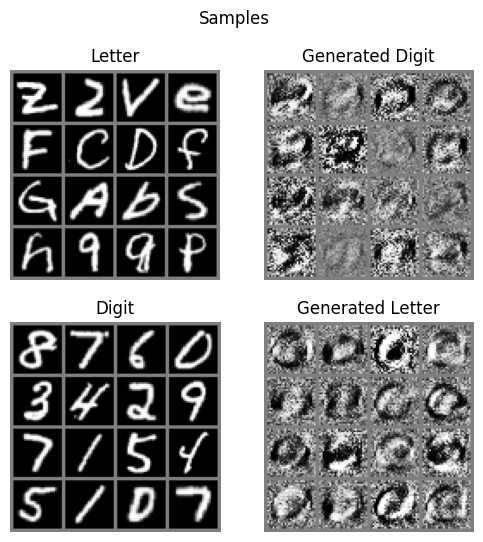

In [25]:
conditional_q.to('cpu')
conditional_p.to('cpu')

conditional_q.eval()
conditional_p.eval()

visualize_sb_images(conditional_p, conditional_q, letters_set, digits_set, x_title='Letter', y_title='Digit', num_samples=16)

In [ ]:
torch.save(conditional_p.state_dict(), '../models/emnist3_conditional_p.pt')
torch.save(conditional_q.state_dict(), '../models/emnist3_conditional_q.pt')

In [ ]:
conditional_p = Conditional(hidden_dims=[256, 256])
conditional_p.load_state_dict(torch.load('../models/emnist3_conditional_p.pt'))

conditional_q = Conditional(hidden_dims=[256, 256])
conditional_q.load_state_dict(torch.load('../models/emnist3_conditional_q.pt'))

<All keys matched successfully>